In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import ndimage
from matplotlib.animation import FFMpegWriter
import cv2
import src.procrustes as procrustes
import src.utils as utils

In [16]:
from skeleton import skeleton
G, color_edge = skeleton()

def read_cropped_image(f):
    return cv2.imread('/data/LiftFly3D/flylimbtracker/data/flylimbtracker_data/labeled-data/cropped/img{:03d}.png'.format(f))[:,:,0]

def read_image(f):
    return cv2.imread('/data/LiftFly3D/flylimbtracker/data/frames/{:03d}.png'.format(f))[:,:,0]

# Load hand annotated data

In [17]:
n_frames = 100
bottom = pd.read_hdf('/data/LiftFly3D/flylimbtracker/data/flylimbtracker_data/labeled-data/cropped/CollectedData_Adam Gosztolai.h5')
bottom = bottom.reset_index()
bottom = bottom.droplevel('scorer',axis=1)
bottom = bottom.iloc[:,1:]
bottom_np = bottom.loc[:n_frames-1,(slice(None),['x','y'])].to_numpy()
points2d = np.stack((bottom_np[:,::2], bottom_np[:,1::2]), axis=2)
imgs = [read_cropped_image(t) for t in range(n_frames)]

In [18]:
points2d.shape

(100, 30, 2)

# Cropped image

(-0.5, 999.5, 999.5, -0.5)

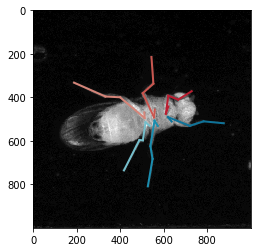

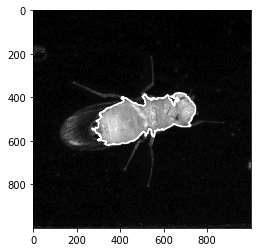

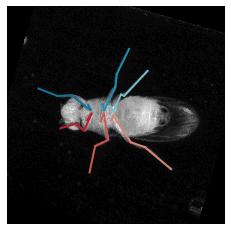

In [19]:
t = 0

angle, contour = procrustes.orientation(imgs[t], 90)
pos_rot, angle = procrustes.center_and_align(points2d[t,:,:], angle, c=[imgs[t].shape[0]//2, imgs[t].shape[1]//2])
img_rot = ndimage.rotate(imgs[t], np.degrees(angle), reshape=False)

#skeleton
plt.figure()
plt.imshow(imgs[t])
plt.imshow(imgs[t], cmap='gray')
utils.plot_skeleton(G, points2d[t,:,0], points2d[t,:,1], color_edge)

#contour
plt.figure()
plt.imshow(imgs[t], cmap='gray')
plt.plot(contour[:,0], contour[:,1], c='white')

#aligned
plt.figure()
plt.imshow(img_rot, cmap='gray')
utils.plot_skeleton(G, pos_rot[:,0], pos_rot[:,1], color_edge)
plt.axis('off')
#plt.savefig('fly.png',dpi=300)

# Whole arena

(-0.5, 2559.5, 917.5, -0.5)

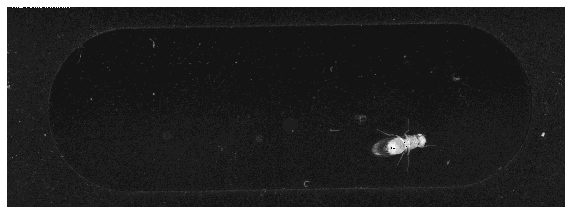

In [20]:
plt.figure(figsize=(10,10))
img = read_image(0)
plt.imshow(img*10, cmap='gray')
plt.axis('off')
#cv2.imwrite('arena.png',img*10)

Video

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

writer = FFMpegWriter(fps=10)
with writer.saving(fig, "arena.mp4", 100):
    for frame_idx in range(n_frames):
        plt.cla()

        img = read_image(frame_idx)
        plt.imshow(img*10 , cmap='gray')
        #plot_skeleton(points2d[frame_idx,:,0], points2d[frame_idx,:,1], ids, color_edge)

        plt.axis('off')
        writer.grab_frame() 

# Align frames

In [33]:
points2d_aligned = np.zeros_like(points2d)
imgs_aligned = []
for frame_idx in range(n_frames):
    
    angle, contour = procrustes.orientation(imgs[frame_idx], 90)
    pos_rot, angle = procrustes.center_and_align(points2d[frame_idx,:,:], angle, c=[imgs[frame_idx].shape[0]//2, imgs[frame_idx].shape[1]//2])
    img_rot = ndimage.rotate(imgs[frame_idx], np.degrees(angle), reshape=False)
        
    points2d_aligned[frame_idx,:,:] = pos_rot    
    imgs_aligned.append(img_rot)

Fine adjust to body-coxas and save

In [34]:
body_coxas = [1, 6, 11, 16, 21, 26]
points2d_aligned = procrustes.procrustes_on_keypoints(points2d_aligned, body_coxas)

# Make ventral video

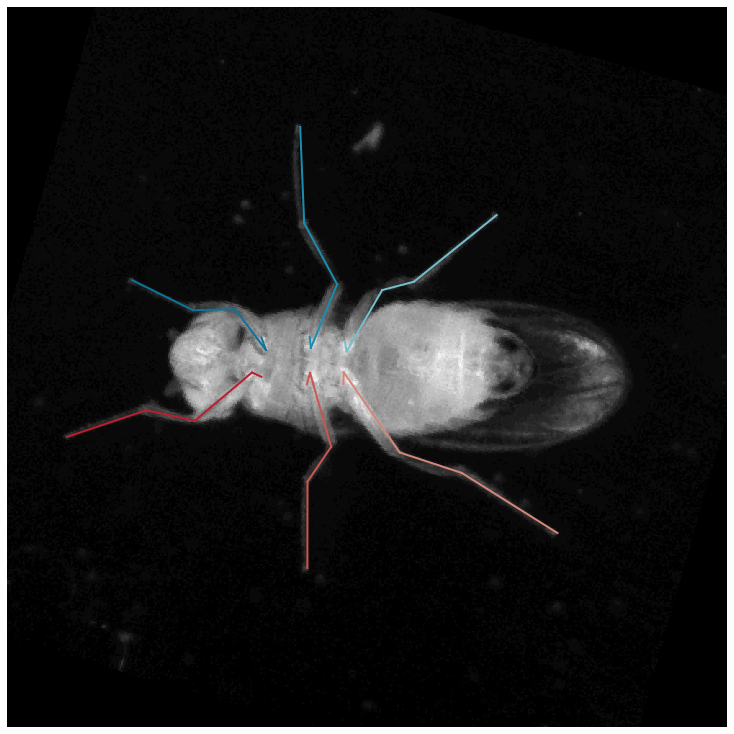

In [8]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

writer = FFMpegWriter(fps=10)
with writer.saving(fig, "cropped.mp4", 100):
    for frame_idx in range(0, n_frames):
        plt.cla()

        plt.imshow(imgs_aligned[frame_idx], cmap='gray')
        utils.plot_skeleton(G, points2d_aligned[frame_idx,:,0], points2d_aligned[frame_idx,:,1], color_edge)
        
        #plt.text(120, 80, str(frame_idx), fontsize=20, color='white')

        plt.axis('off')
        writer.grab_frame() 

# Adjust to template and save

In [35]:
template_dir = '/data/LiftFly3D/flylimbtracker/network/'
prism_template = pickle.load(open(template_dir + '191125_PR_Fly1_001_prism.pkl','rb'))['points2d']
_, _, R,scale,t = procrustes.compute_similarity_transform(prism_template[0,:,:,:].mean(axis=0)[body_coxas,:], points2d_aligned[:, body_coxas,:].mean(axis=0),compute_optimal_scale=True)

for frame_idx in range(n_frames):
    points2d_aligned[frame_idx,:,:] = scale*np.dot(points2d_aligned[frame_idx,:,:], R) + t

#points2d_aligned[:,:,0] = utils.filter_data(points2d_aligned[:,:,0], window=3, order=2)
#points2d_aligned[:,:,1] = utils.filter_data(points2d_aligned[:,:,1], window=3, order=2)
    
pickle.dump({"points2d": points2d_aligned}, open('/data/LiftFly3D/flylimbtracker/data/flylimbtracker_filt.pkl', 'wb'))

In [36]:
scale

0.5882845600506567

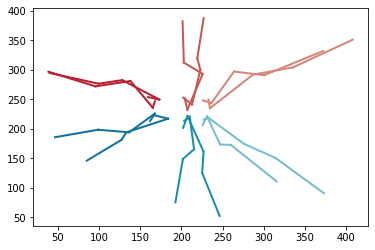

In [31]:
t = 5
utils.plot_skeleton(G, prism_template[0,t,:,0], prism_template[0,t,:,1], color_edge)
utils.plot_skeleton(G, points2d_aligned[t,:,0], points2d_aligned[t,:,1], color_edge)

# Distributions

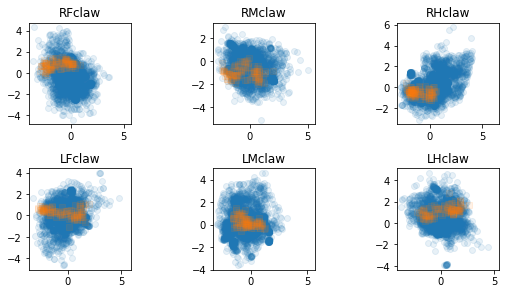

In [32]:
import torch 
tint = [0,n_frames]
times = np.arange(tint[0],tint[1])
times_prism = np.arange(4000)

prism_dir = '/data/LiftFly3D/flylimbtracker/network/'
optobot_dir = "/data/LiftFly3D/flylimbtracker/data/"

poses_optobot = torch.load(optobot_dir + 'test_2d.pth.tar')
poses_prism = torch.load(prism_dir + 'train_2d.pth.tar')

poses_optobot = np.concatenate([v for k,v in poses_optobot.items()], 0)
poses_prism = np.concatenate([v for k,v in poses_prism.items()], 0)

poses_optobot = np.stack((poses_optobot[:,::2], poses_optobot[:,1::2]), axis=2)
poses_prism = np.stack((poses_prism[:,::2], poses_prism[:,1::2]), axis=2)

fig = plt.figure(figsize=([8,8])) 

leg_tips = ['RFclaw', 'RMclaw', 'RHclaw', 'LFclaw', 'LMclaw', 'LHclaw']
joint_id = [3, 7, 11, 15, 19, 23] #legtips
for i, k in enumerate(joint_id):
    fig.add_subplot(4,3,i+1)
    plt.title(leg_tips[i])
    
    plt.plot(poses_prism[times_prism,k,0], poses_prism[times_prism,k,1],'o',alpha=0.1)  
    plt.plot(poses_optobot[times,k,0], poses_optobot[times,k,1],'s',alpha=0.1)
    plt.axis('square')
    
plt.tight_layout()
plt.savefig('distribution.svg')